<a href="https://colab.research.google.com/github/soneyahossain/deep_learning_project/blob/master/modelExperimentWithDataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        #print(image_ids[0])
        #print(label_ids[0])
        #print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_,image_name,class_name
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


trainset = UVaBuildinglabel('../DATA', '../DATA/DATA2trainSet.csv')
valset = UVaBuildinglabel('../DATA', '../DATA/DATA2valSet.csv')

print("total training data",trainset.__len__())
print("total validation data",valset.__len__())

Loading data...
Loading data...
total training data 616
total validation data 616


In [5]:
def train_model(net, loss_fn, batchsize, trainset, valset, optimizer, num_epochs):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,shuffle=False, num_workers=2)

    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    
    N = num_epochs
    net=net.cuda()
    loss_fn = loss_fn.cuda()

    for epoch in range(N):  # loop over the dataset multiple times
        #print(epoch)
        correct = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _, _ = data

            #print(inputs.shape)
            #print(labels.shape)
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print(outputs.shape)
            #print(labels)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_scores, max_labels = outputs.max(1)

            #print(max_scores)
            #print(max_labels)

            correct += (max_labels == labels).sum().item()
            if (i+1) % (20) == 0:    # print every 10 mini-batches
                print('Train: [%d, %5d] loss: %.3f Accuracy: %.4f' %
                      (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
                running_loss = 0.0
        
        train_accuracies.append(correct / len(trainset))
        train_losses.append(running_loss / (i + 1))  

        net.eval()
        correct = 0
        running_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            running_loss += loss_fn(outputs, labels).item()

            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()

        print('Validation: [%d, %5d] loss: %.3f Accuracy: %.4f' % 
              (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
        
        val_accuracies.append(correct / len(valset))
        val_losses.append(running_loss / (i + 1))
            
    print('Finished Training')


    plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses, 'bo-', label = 'val-loss')
    plt.plot(train_losses, 'ro-', label = 'train-loss')
    plt.grid('on')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['validation', 'training'], loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'bo-', label = 'val-acc')
    plt.plot(train_accuracies, 'ro-', label = 'train-acc')
    plt.ylabel('accuracy')
    plt.grid('on')
    plt.xlabel('epoch')
    plt.legend(['validation', 'training'], loc='lower right')
    plt.show()

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,shuffle=True)
no_images_per_class = torch.zeros(20)
for (i, (my_image, my_label,_,class_name)) in enumerate(trainloader):    
  no_images_per_class[my_label.item()]+=1  

print(no_images_per_class)
#weight for loss 
class_weights = 64/no_images_per_class   #as 64 is the miximum no of immage in a category
class_weights=torch.FloatTensor(class_weights)

print(class_weights)

tensor([19., 13., 55., 27., 64., 47., 47., 16., 20., 20., 20., 23., 39., 49.,
        28., 24., 17., 20., 24., 44.])
tensor([3.3684, 4.9231, 1.1636, 2.3704, 1.0000, 1.3617, 1.3617, 4.0000, 3.2000,
        3.2000, 3.2000, 2.7826, 1.6410, 1.3061, 2.2857, 2.6667, 3.7647, 3.2000,
        2.6667, 1.4545])


Train: [1,    20] loss: 4.170 Accuracy: 0.0437
Train: [1,    40] loss: 2.513 Accuracy: 0.0688
Train: [1,    60] loss: 1.967 Accuracy: 0.0833
Validation: [1,    20] loss: 3.539 Accuracy: 0.3438
Train: [2,    20] loss: 3.543 Accuracy: 0.3750
Train: [2,    40] loss: 2.169 Accuracy: 0.4250
Train: [2,    60] loss: 1.696 Accuracy: 0.5021
Validation: [2,    20] loss: 2.686 Accuracy: 0.7562
Train: [3,    20] loss: 2.745 Accuracy: 0.7438
Train: [3,    40] loss: 1.823 Accuracy: 0.7312
Train: [3,    60] loss: 1.481 Accuracy: 0.7354
Validation: [3,    20] loss: 2.051 Accuracy: 0.8250
Train: [4,    20] loss: 2.180 Accuracy: 0.8562
Train: [4,    40] loss: 1.481 Accuracy: 0.8844
Train: [4,    60] loss: 1.312 Accuracy: 0.8750
Validation: [4,    20] loss: 1.618 Accuracy: 0.8688
Train: [5,    20] loss: 1.697 Accuracy: 0.9125
Train: [5,    40] loss: 1.327 Accuracy: 0.9187
Train: [5,    60] loss: 1.193 Accuracy: 0.9229
Validation: [5,    20] loss: 1.361 Accuracy: 0.9187
Finished Training


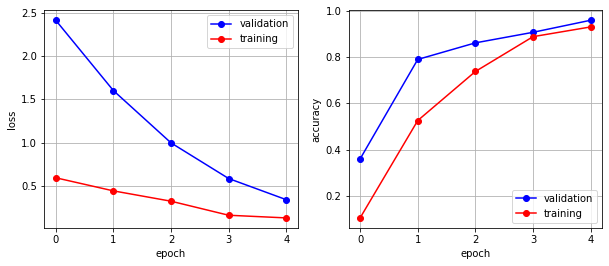

In [5]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

#weight=class_weights
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
resnet = models.resnet50(pretrained = True)

#print(len(trainset.image_classes))
resnet.fc = nn.Linear(2048, 20)
optimizer = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnet, loss_fn, 8, trainset, valset, optimizer, 5)  

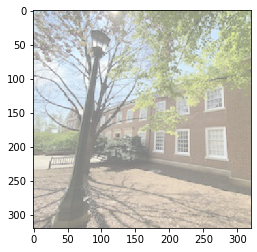

GroundTruth:  ('Olsson Hall',)
Predicted:  Olsson Hall


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])


In [7]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = resnet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

resnetAccuracy = open('../results/accuracy/resnetDataSet2Accuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    resnetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
resnetAccuracy.close()  

resnetConfusion = open('../results/confusion/resnetDataSet2Confusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    resnetConfusion.write(line)
resnetConfusion.close()

accuracy for  Alderman Library is :  1.0
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  1.0
accuracy for  Chemical Engineering Building is :  1.0
accuracy for  John Paul Jones Arena is :  0.8666666746139526
accuracy for  Law School Building is :  0.9230769276618958
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  0.75
accuracy for  Newcomb Hall is :  0.5
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  0.9230769276618958
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


Train: [1,    20] loss: 8.813 Accuracy: 0.0563
Train: [1,    40] loss: 2.920 Accuracy: 0.2219
Train: [1,    60] loss: 1.704 Accuracy: 0.3500
Validation: [1,    20] loss: 1.587 Accuracy: 0.8250
Train: [2,    20] loss: 1.641 Accuracy: 0.8625
Train: [2,    40] loss: 1.335 Accuracy: 0.8469
Train: [2,    60] loss: 1.154 Accuracy: 0.8562
Validation: [2,    20] loss: 1.261 Accuracy: 0.9000
Train: [3,    20] loss: 1.235 Accuracy: 0.9625
Train: [3,    40] loss: 1.094 Accuracy: 0.9563
Train: [3,    60] loss: 1.098 Accuracy: 0.9500
Validation: [3,    20] loss: 1.177 Accuracy: 0.9250
Train: [4,    20] loss: 1.199 Accuracy: 0.9250
Train: [4,    40] loss: 1.061 Accuracy: 0.9469
Train: [4,    60] loss: 1.050 Accuracy: 0.9500
Validation: [4,    20] loss: 1.126 Accuracy: 0.9313
Train: [5,    20] loss: 1.136 Accuracy: 0.9750
Train: [5,    40] loss: 1.033 Accuracy: 0.9812
Train: [5,    60] loss: 1.027 Accuracy: 0.9833
Validation: [5,    20] loss: 1.080 Accuracy: 0.9437
Train: [6,    20] loss: 1.079 Accur

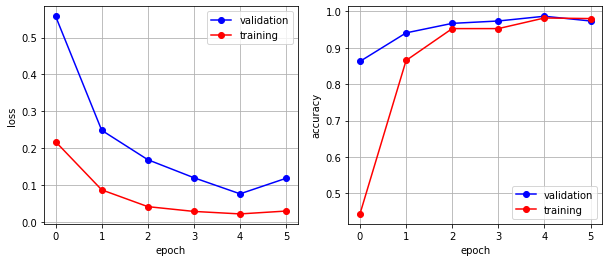

In [8]:
loss_fn = nn.CrossEntropyLoss()
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.fc = nn.Linear(2048, 20)
optimizer = optim.SGD(mobilenet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(mobilenet, loss_fn, 8, trainset, valset, optimizer, 6)   #epoch 6 can give better results

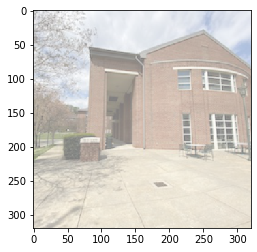

GroundTruth:  ('Aquatic & Fitness Center',)
Predicted:  Aquatic & Fitness Center


In [9]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [10]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = mobilenet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

mobilenetAccuracy = open('../results/accuracy/mobilenetDataSet2Accuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    mobilenetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
mobilenetAccuracy.close()  

mobilenetConfusion = open('../results/confusion/mobilenetDataSet2Confusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    mobilenetConfusion.write(line)
mobilenetConfusion.close()

accuracy for  Alderman Library is :  0.75
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  0.9333333373069763
accuracy for  Chemical Engineering Building is :  1.0
accuracy for  John Paul Jones Arena is :  0.9333333373069763
accuracy for  Law School Building is :  1.0
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  1.0
accuracy for  Newcomb Hall is :  0.25
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


Train: [1,    20] loss: 4.314 Accuracy: 0.0625
Train: [1,    40] loss: 2.458 Accuracy: 0.1250
Train: [1,    60] loss: 1.820 Accuracy: 0.2167
Train: [1,    80] loss: 1.606 Accuracy: 0.2437
Train: [1,   100] loss: 1.411 Accuracy: 0.2775
Train: [1,   120] loss: 1.314 Accuracy: 0.3063
Train: [1,   140] loss: 1.238 Accuracy: 0.3411
Validation: [1,    39] loss: 2.407 Accuracy: 0.5705
Train: [2,    20] loss: 2.646 Accuracy: 0.6000
Train: [2,    40] loss: 1.627 Accuracy: 0.6250
Train: [2,    60] loss: 1.478 Accuracy: 0.6292
Train: [2,    80] loss: 1.333 Accuracy: 0.6312
Train: [2,   100] loss: 1.250 Accuracy: 0.6425
Train: [2,   120] loss: 1.160 Accuracy: 0.6542
Train: [2,   140] loss: 1.136 Accuracy: 0.6571
Validation: [2,    39] loss: 1.915 Accuracy: 0.7115
Train: [3,    20] loss: 1.495 Accuracy: 0.8875
Train: [3,    40] loss: 1.376 Accuracy: 0.8438
Train: [3,    60] loss: 1.211 Accuracy: 0.8333
Train: [3,    80] loss: 1.279 Accuracy: 0.7937
Train: [3,   100] loss: 1.152 Accuracy: 0.7900
Tra

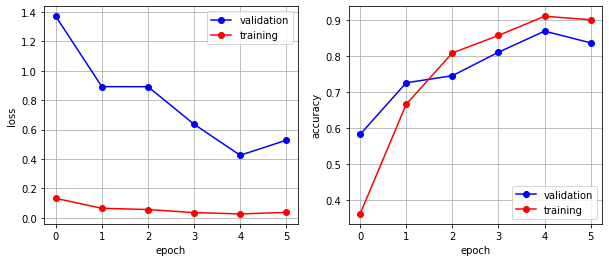

In [11]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 20)
optimizer = optim.SGD(alexnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(alexnet, loss_fn, 4, trainset, valset, optimizer, 6)  #epoch 6 worked better

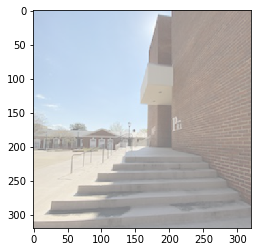

GroundTruth:  ('Mechanical Building',)
Predicted:  Mechanical Building


In [12]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [13]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = alexnet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

alexnetAccuracy = open('../results/accuracy/alexnetDataSet2Accuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    alexnetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
alexnetAccuracy.close()  

alexnetConfusion = open('../results/confusion/alexnetDataSet2Confusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    alexnetConfusion.write(line)
alexnetConfusion.close()

accuracy for  Alderman Library is :  0.75
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  0.9333333373069763
accuracy for  Chemical Engineering Building is :  1.0
accuracy for  John Paul Jones Arena is :  0.8666666746139526
accuracy for  Law School Building is :  0.7692307829856873
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  0.6666666865348816
accuracy for  Monroe Hall is :  0.75
accuracy for  Newcomb Hall is :  0.5
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  0.4000000059604645
accuracy for  Olsson Hall is :  0.9090909361839294
accuracy for  Physics Building is :  0.9230769276618958
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  0.6000000238418579
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  0.6666666865348816
accuracy for  Wilsdorf Hall is :  0.5833333134651184
